In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import requests
import json
import time
from tqdm.auto import tqdm
import math
import os, os.path

import ast
import re
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
import gensim
import gensim.downloader

import matplotlib.pyplot as plt
from gensim.models.phrases import Phrases, Phraser
from gensim.models import KeyedVectors
import seaborn as sns

from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import AgglomerativeClustering

import os
import urllib.request
from scipy import spatial
from sklearn.manifold import TSNE
from numpy import dot
from numpy.linalg import norm



In [2]:
def get_description_embedding_avg(description, emmbed_dict, embed_dim):
    embedding = np.zeros(embed_dim)
    if (description):
        n = len(description)
        for i, ele in enumerate(description):
            try:
                embedding += emmbed_dict[ele]
            except:
                pass
        return embedding/n
    return embedding

def get_description_embedding_max(description, emmbed_dict, embed_dim):
    embedding = np.zeros(embed_dim)
    if (description):
        n = len(description)
        for i, ele in enumerate(description):
            try:
                embedding = np.maximum(embedding, emmbed_dict[ele])
            except:
                pass
        return embedding
    return embedding
    
def cosine(a,b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim

def get_embedding_dict (path):
  emmbed_dict = {}
  with open(path,'r') as f:
    for line in f:
      values = line.split()
      word = values[0]
      vector = np.asarray(values[1:],'float32')
      emmbed_dict[word]=vector
  return emmbed_dict

def get_all_embedding(descriptions_, embed_fun, embed_dict, embed_dim ):
    vectors =[]
    for ele in tqdm(descriptions_):
        vectors.append(embed_fun(ele,embed_dict,embed_dim))
    return vectors

def get_row_embedding(row, embed_fun, embed_dict, embed_dim ):
    if (type(row)==str):
        list_tokens = ast.literal_eval(row)
        return embed_fun(list_tokens, embed_dict, embed_dim) 
    else:
        return np.zeros(50)

def find_indices(list_to_check, item_to_find):
    array = np.array(list_to_check)
    indices = np.where(array == item_to_find)[0]
    return list(indices)

def give_examples_of_clusters(num, clustering):
    examples = []
    labels = np.unique(clustering.labels_)
    for i in labels:
        examples.append(np.random.choice(find_indices(clustering.labels_,i), size=num))
    return examples

In [140]:
df = pd.read_csv("tokenized_tags.csv", low_memory=False, lineterminator='\n')

In [4]:
df.head()

,Unnamed: 0.1,Unnamed: 0,id,name,description,number_of_employees,seo_description,annual_revenue_estimation,address,founding_year,languages_spoken_at_company,geo_lon,geo_lat,industries,keywords,eng_industries,eng_keywords,tokens_industries,tokens_keywords
0,0,0,10293,Renesas Electronics Corporation,Renesas Electronics Corporation is a Japanese ...,10000,"A global leader in microcontrollers, analog, p...",1.000000e+09,"2880 Scott Blvd, 135-0061, Koto City, Tokyo, J...",2002,"['English', 'Chinese']",-121.959064,37.372658,"['Halbleiter', 'marketing', 'information_techn...","['hardware', 'information technology', 'semico...","['semiconductor', 'marketing', 'information_te...","['hardware', 'information technology', 'semico...","['semiconductor', 'marketing', 'information', ...","['hardware', 'information', 'technology', 'sem..."
1,1,1,10294,Klüber Lubrication München SE & Co. KG,Benefit from our comprehensive range of specia...,5000,"Benefíciese de nuestra consultoría experta, de...",1.000000e+07,"7 Geisenhausenerstraße, 03053, München, Bayern...",1929,NaN,NaN,NaN,"['Chemieindustrie', 'Chemikalien', 'Wälzlagerf...","['ceras lubrificantes', 'lubrificantes especia...","['chemical industry', 'chemicals', 'roller bea...","[None, 'special lubricants', 'industrial lubri...","['chemical', 'industry', 'chemicals', 'roller'...","['special', 'lubricants', 'industrial', 'lubri..."
2,2,2,10295,RHINE BUSINESS CONSULTING,Als unabhängiges Beratungshaus unterstützen wi...,10,Kompetenz in Business Development und Digitali...,2.000000e+06,"55270, Jugenheim, Deutschland",2015,NaN,NaN,NaN,"['Management Beratung', 'Management Beratung']","['it interim project management', 'big data am...","['management consulting', 'management consulti...","[None, 'big data amp predictive analytics', No...","['management', 'consulting', 'management', 'co...","['big', 'data', 'amp', 'predictive', 'analytic..."
3,3,3,10296,EMIL,Zahle pro gefahrenem Kilometer Spare bis zu 45...,50,"Versicherer nutzen die EMIL Insurance Suite, u...",1.000000e+07,"94103, Berlin, Lower Saxony, Germany",2017,NaN,NaN,NaN,"['Versicherung', 'Insurance company']",NaN,"['insurance', 'Insurance company']",NaN,"['insurance', 'insurance', 'company']",NaN
4,4,4,10297,Carnival Maritime,Carnival Maritime is the Marine Service Unit o...,500,NaN,5.000000e+07,"9 Großer Grasbrook, 20457, Hamburg, Hamburg, G...",2015,NaN,9.993667,53.542124,"['Seeschiffahrt und maritime Wirtschaft', 'ope...","['maritime', 'maritime]']","['Shipping and maritime economy', 'operations'...","['maritime', 'maritime]']","['shipping', 'maritime', 'economy', 'operation...","['maritime', 'maritime']"


In [5]:
companies_isna_stats = df.isna().sum() / df.shape[0] * 100
companies_isna_stats

Unnamed: 0.1                    0.000000
Unnamed: 0                      0.000000
id                              0.000000
name                            0.000387
description                     7.709944
number_of_employees             9.291954
seo_description                57.704779
annual_revenue_estimation      23.625966
address                         4.058573
founding_year                  33.130464
languages_spoken_at_company    43.747400
geo_lon                        42.654989
geo_lat                        42.654989
industries                     11.903619
keywords                       25.109874
eng_industries                 11.903619
eng_keywords                   25.109874
tokens_industries              11.903619
tokens_keywords                25.109874
dtype: float64

In [6]:
path_glv_50 = 'glove.6B.50d.txt'
embed_glv_50 = get_embedding_dict(path_glv_50)
tqdm.pandas()

In [10]:
df["ind_embed"] = df["eng_industries"].progress_apply(lambda row :  get_row_embedding(row, get_description_embedding_max, embed_glv_50, 50 ))  


  0%|          | 0/2846000 [00:00<?, ?it/s]

In [11]:
df["kw_embed"] = df["eng_keywords"].progress_apply(lambda row :  get_row_embedding(row, get_description_embedding_avg, embed_glv_50, 50 ))  


  0%|          | 0/2846000 [00:00<?, ?it/s]

In [13]:
def get_embeddings(df):
    ind_embeddings = df["tokens_industries"].progress_apply(lambda row :  get_row_embedding(row, get_description_embedding_avg, embed_glv_50, 50 )).values
    kw_embeddings = df["tokens_keywords"].progress_apply(lambda row :  get_row_embedding(row, get_description_embedding_avg, embed_glv_50, 50 )).values
    embeddings = []

    for i in range(len(ind_embeddings)):
        embeddings.append(ind_embeddings[i] + kw_embeddings[i])

    return embeddings

In [14]:
embeddings = get_embeddings(df)

  0%|          | 0/2846000 [00:00<?, ?it/s]

  0%|          | 0/2846000 [00:00<?, ?it/s]

In [12]:
embeddings

[]

In [15]:
df["embeddings"] = embeddings

In [16]:
embeddings[57]

array([ 0.07875757, -0.28225143,  0.27341871,  0.44837144, -0.12275472,
       -0.13468143, -0.58289429, -0.56850571,  0.16874572,  0.25851015,
        0.32211128,  0.15762143, -0.23002958, -0.12725671, -0.11829614,
        0.13206029, -0.24951143,  0.40757287,  0.15456142, -0.35798857,
        0.84687286, -0.10789428, -0.44287858, -0.06236143, -0.22171714,
       -0.63760573, -0.23987143, -0.28507543,  0.08120557,  0.05703428,
        1.93360002, -0.23732857,  0.19351428, -0.13126286, -0.08093814,
       -0.19853714, -0.45095857,  0.26322571,  0.42143142, -0.08086143,
        0.11764143, -0.26758572,  0.21694285,  0.09214999,  0.04466086,
        0.09810372, -0.12502428,  0.18702142,  0.15063429,  0.20134714])

In [17]:
embedd = np.vstack(list(df["embeddings"].values))

In [18]:
np.any(np.isnan(embedd))

False

In [133]:
z, t = np.where(np.isnan(embedd))

In [135]:
z, t

(array([     57,      57,      57, ..., 2767827, 2767827, 2767827]),
 array([ 0,  1,  2, ..., 47, 48, 49]))

In [136]:
embedd[57]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [56]:
np.all(np.isfinite(embedd))


False

In [52]:
kmeans = KMeans(n_clusters=25, random_state=1).fit(embedd)

In [12]:
#kmeans = KMeans(n_clusters=20, random_state=0, verbose=True).fit(np.array(embedd_list))

In [51]:
connectivity = kneighbors_graph(embedd, n_neighbors=5, include_self=False)

KeyboardInterrupt: 

In [ ]:
ward = AgglomerativeClustering(n_clusters=40, connectivity=connectivity, linkage="ward").fit(np.array(embedd))

In [53]:
examples = give_examples_of_clusters(20, kmeans)

In [78]:
for i in examples[24]:
    print(df["tokens_keywords"].values[i])

['exhibitions', 'music', 'concerts', 'corporate', 'events', 'conferences', 'wedding', 'corporate', 'activities', 'mall', 'activation', 'events', 'services']
['hospitality', 'leisure', 'travel', 'tourism']
['corporate', 'parties', 'openings', 'conferences', 'fundraising', 'campaigns', 'concerts', 'workshops', 'campaigns', 'events', 'services']
['sports', 'active', 'life', 'amateur', 'sports', 'teams']
['virtual', 'office', 'support', 'meetings', 'events', 'lifestyle', 'support', 'meetings', 'amp', 'events', 'pa', 'services', 'project', 'support', 'events', 'services']
['hiking', 'biking', 'birdwatching', 'hospitality', 'leisure', 'travel', 'tourism']
['sports', 'event', 'sports', 'consultancy', 'sports']
['soccer', 'sport', 'athletic', 'training', 'training', 'sports', 'training']
['gambling', 'casinos', 'leisure', 'travel', 'tourism']
['hospitality', 'leisure', 'travel', 'tourism']
['hospitality', 'leisure', 'travel', 'tourism']
['recreational', 'facilities', 'services']
['hospitality'

In [160]:
neigh = NearestNeighbors(n_neighbors=2, radius=0.4)
#neigh.fit(X)
neigh.fit(np.array(embedd))

NearestNeighbors(n_neighbors=2, radius=0.4)

In [203]:
indx =  69
neighbours = neigh.kneighbors([np.array(embedd)[indx]], 10, return_distance=False)
#13, 14, 18, 46, 21, 24, 50, 52, 58, 19, 97, 69

In [204]:
df["tokens_industries"].values[indx]

"['mental', 'health', 'care']"

In [205]:
for i in neighbours:
    print(df["tokens_industries"].values[i])

["['mental', 'health', 'care']" nan nan nan nan "['philanthropie']" nan
 "['philanthropie']"
 "['mental', 'health', 'care', 'informationstechnologie']"
 "['mental', 'health', 'care', 'informationstechnologie']"]


In [46]:
rand_idx = np.random.choice(len(embedd),100000)

In [47]:
samples = embedd[rand_idx]

In [48]:
Xtsne = TSNE(n_components=2, verbose=True).fit_transform(samples)
dftsne = pd.DataFrame(Xtsne)

/Users/ahmedewva/opt/anaconda3/envs/idp/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/ahmedewva/opt/anaconda3/envs/idp/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100000 samples in 0.011s...
[t-SNE] Computed neighbors for 100000 samples in 200.673s...
[t-SNE] Computed conditional probabilities for sample 1000 / 100000
[t-SNE] Computed conditional probabilities for sample 2000 / 100000
[t-SNE] Computed conditional probabilities for sample 3000 / 100000
[t-SNE] Computed conditional probabilities for sample 4000 / 100000
[t-SNE] Computed conditional probabilities for sample 5000 / 100000
[t-SNE] Computed conditional probabilities for sample 6000 / 100000
[t-SNE] Computed conditional probabilities for sample 7000 / 100000
[t-SNE] Computed conditional probabilities for sample 8000 / 100000
[t-SNE] Computed conditional probabilities for sample 9000 / 100000
[t-SNE] Computed conditional probabilities for sample 10000 / 100000
[t-SNE] Computed conditional probabilities for sample 11000 / 100000
[t-SNE] Computed conditional probabilities for sample 12000 / 100000
[t-SNE] Computed conditional proba

In [98]:
labels_tags = ["Transportation", "Nan", "Insurance","Management", "Technology","Nan", "Health care", "HR", "Construction","Security","Nan","Fashion","Media","Machinery","Media","Sales & Strategy", "Real estate","Education", "Energy & Mining", "Food", "Agriculture/Design", "Retail & Ecommerce", "Art", "Health & Fitness", "Tourism & Leisure"]
clusters = kmeans.labels_[rand_idx]
clusters_tags = [labels_tags[clusters[i]] for i in range(len(clusters))]

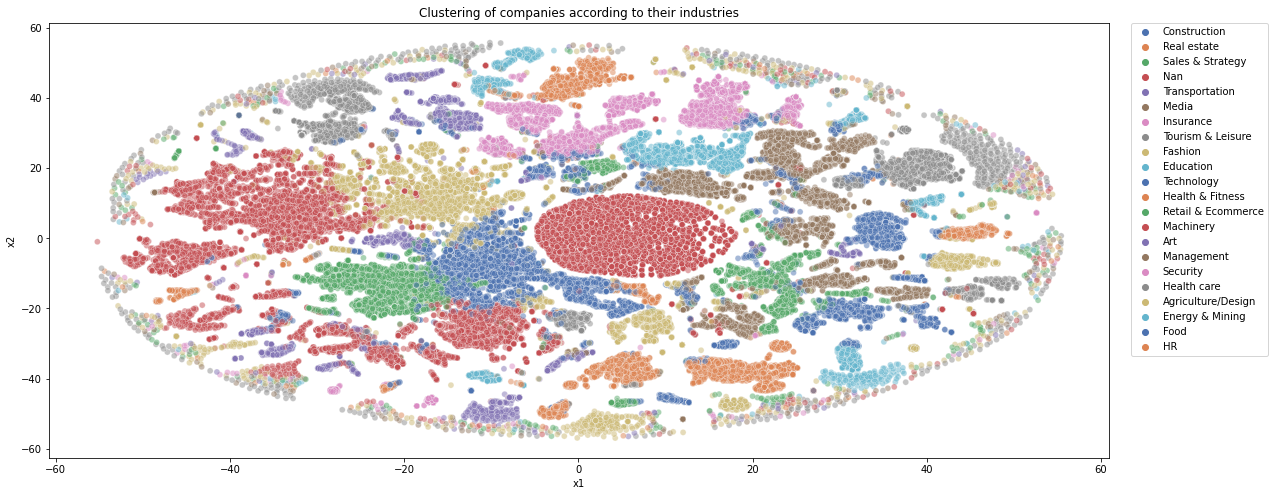

In [101]:
dftsne['cluster'] = clusters_tags
dftsne.columns = ['x1','x2','cluster']
fig, ax = plt.subplots(1, figsize=(19,8))
sns.scatterplot(data=dftsne,x='x1',y='x2',hue='cluster',legend="full",  palette="deep",alpha=0.5,ax=ax)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

ax.set_title('Clustering of companies according to their industries')
plt.savefig("clustering.jpg")

In [92]:
labels_tags = ["Transportation", "Nan", "Insurance","Business & Management", "Inforomation technology","Nan", "Health care", "HR", "Construction","Security","Nan","Fashion","Media","Machinery","Media","Sales & Strategy", "Real estate","Education", "Energy & Mining", "Food", "Agriculture/Design", "Retail & Ecommerce & Logistics", "Art", "Health & Fitness", "Tourism & Leisure"]
clusters = kmeans.labels_[rand_idx]
clusters_tags = [labels_tags[clusters[i]] for i in range(len(clusters))]

In [93]:
clusters = kmeans.labels_[rand_idx]
clusters_tags = [labels_tags[clusters[i]] for i in range(len(clusters))]

In [89]:

for i in range(len(clusters)):
    print(i)
    print(labels_tags[clusters[i]] )


0
Construction
1
Education
2
Construction
3
Sales & Strategy
4
Nan
5
Nan
6
Transportation
7
Nan
8
Media
9
Insurance
10
Nan
11


IndexError: list index out of range

In [81]:
len(labels_tags)

24

In [50]:
kmeans.labels_[rand_idx]

array([ 5,  5,  1, ...,  8, 10,  5], dtype=int32)

In [114]:
df["ind_embed"].values[0]

1.15910005569458

In [102]:
def distribution_employees(num_employees):
    if (num_employees<50):
        return 1
    elif (num_employees>250):
        return 3
    else:
        return 2

def distribution_revenues(revenues):
    if (revenues<=1000000):
        return 1
    elif (revenues>1000000 and revenues<=10000000):
        return 2
    elif (revenues>10000000 and revenues<=50000000):
        return 3
    elif (revenues>10000000):
        return 4
    else:
        return 5

def range_to_value(range_):
    if range_=='1-10' or range_=='1-9':
        return '10'
    elif range_=='11-50' or range_=='10-49':
        return '30'
    elif range_=='11-100':
        return '50'
    elif range_=='201-500' or range_=='200+' or range_=='101-500':
        return '350'
    elif range_=='51-200' or range_=='50-199':
        return '150'
    else:
        return range_

def get_size(num_employees, revenue):
    revenue = distribution_revenues(revenue)
    num_employees = distribution_employees(num_employees)
    if (revenue ==1 or num_employees==1):
        return 0
    elif (revenue ==4 or num_employees==3):
        return 2
    else: 
        return 1

In [103]:
employees = []
for i in df["number_of_employees"].values:
    try:
        employees.append(float(range_to_value(i)))
    except:
        employees.append(40)
revenues = []
for i in df["annual_revenue_estimation"].values:
    try:
        revenues.append(float(range_to_value(i)))
    except:
        revenues.append(1000000)
sizes = [get_size(employees[i],revenues[i]) for i in range(len(employees))]
df["size"] = sizes

In [208]:
df["embeddings"][0]

array([ 7.13898995e-02, -5.00152392e-01,  1.11182200e+00,  1.37079855e+00,
       -4.48037687e-02, -2.91285743e-01, -7.54504283e-01, -1.81188233e+00,
        7.10546882e-01,  4.97555381e-01,  9.70842974e-01,  2.51135796e-01,
       -5.69272618e-01, -8.14083012e-02, -4.93660429e-01,  7.60618039e-01,
       -7.02348559e-01,  8.89596555e-01,  6.81687831e-01, -8.64430300e-01,
        1.75243490e+00, -2.80287830e-01, -9.89312193e-01, -6.76528674e-01,
       -3.69135849e-01, -1.60492448e+00, -5.82463003e-01, -1.04293985e+00,
        1.20538740e-01,  2.86592950e-01,  5.28826579e+00, -3.42341218e-01,
        2.97237370e-01, -1.10298046e+00, -1.70448738e-03,  5.86643993e-02,
       -6.78480847e-01,  9.52767291e-01,  5.54007961e-01,  7.70702130e-02,
        2.78027778e-01, -3.78051119e-01,  2.61458647e-01,  4.10644771e-01,
        3.92585134e-01,  3.42015683e-01,  9.02863508e-02,  1.00416449e+00,
       -1.71820649e-01,  6.35921630e-01])

In [209]:
df.head()

,Unnamed: 0.1,Unnamed: 0,id,name,description,number_of_employees,seo_description,annual_revenue_estimation,address,founding_year,...,industries,keywords,eng_industries,eng_keywords,tokens_industries,tokens_keywords,ind_embed,kw_embed,embeddings,size
0,0,0,10293,Renesas Electronics Corporation,Renesas Electronics Corporation is a Japanese ...,10000,"A global leader in microcontrollers, analog, p...",1.000000e+09,"2880 Scott Blvd, 135-0061, Koto City, Tokyo, J...",2002,...,"['Halbleiter', 'marketing', 'information_techn...","['hardware', 'information technology', 'semico...","['semiconductor', 'marketing', 'information_te...","['hardware', 'information technology', 'semico...","['semiconductor', 'marketing', 'information', ...","['hardware', 'information', 'technology', 'sem...","[1.15910005569458, 0.6946700215339661, 1.40209...","[-0.14859561192699605, -0.18233888844648996, 0...","[0.07138989954721182, -0.5001523921638726, 1.1...",2
1,1,1,10294,Klüber Lubrication München SE & Co. KG,Benefit from our comprehensive range of specia...,5000,"Benefíciese de nuestra consultoría experta, de...",1.000000e+07,"7 Geisenhausenerstraße, 03053, München, Bayern...",1929,...,"['Chemieindustrie', 'Chemikalien', 'Wälzlagerf...","['ceras lubrificantes', 'lubrificantes especia...","['chemical industry', 'chemicals', 'roller bea...","[None, 'special lubricants', 'industrial lubri...","['chemical', 'industry', 'chemicals', 'roller'...","['special', 'lubricants', 'industrial', 'lubri...","[0.9102200269699097, 0.0, 0.21473999321460724,...","[0.018323199823498726, -0.010754468043645223, ...","[0.14167643975707944, -0.3051478846895474, -0....",2
2,2,2,10295,RHINE BUSINESS CONSULTING,Als unabhängiges Beratungshaus unterstützen wi...,10,Kompetenz in Business Development und Digitali...,2.000000e+06,"55270, Jugenheim, Deutschland",2015,...,"['Management Beratung', 'Management Beratung']","['it interim project management', 'big data am...","['management consulting', 'management consulti...","[None, 'big data amp predictive analytics', No...","['management', 'consulting', 'management', 'co...","['big', 'data', 'amp', 'predictive', 'analytic...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.6586268070069227, -0.19269024961712686, 0.3...",0
3,3,3,10296,EMIL,Zahle pro gefahrenem Kilometer Spare bis zu 45...,50,"Versicherer nutzen die EMIL Insurance Suite, u...",1.000000e+07,"94103, Berlin, Lower Saxony, Germany",2017,...,"['Versicherung', 'Insurance company']",NaN,"['insurance', 'Insurance company']",NaN,"['insurance', 'insurance', 'company']",NaN,"[0.1585800051689148, 0.0, 0.40669000148773193,...",None,"[0.31433000167210895, -0.20447333405415216, 0....",1
4,4,4,10297,Carnival Maritime,Carnival Maritime is the Marine Service Unit o...,500,NaN,5.000000e+07,"9 Großer Grasbrook, 20457, Hamburg, Hamburg, G...",2015,...,"['Seeschiffahrt und maritime Wirtschaft', 'ope...","['maritime', 'maritime]']","['Shipping and maritime economy', 'operations'...","['maritime', 'maritime]']","['shipping', 'maritime', 'economy', 'operation...","['maritime', 'maritime']","[1.15910005569458, 0.03345699980854988, 0.7371...","[0.023770499974489212, -0.10445000231266022, -...","[0.3200681245384308, -0.38927831472112584, -1....",2


In [104]:
ids = df["id"].values
embeddings = df["embeddings"].values
embeddings = np.vstack(embeddings)
sizes = df["size"].values
#locations = df["locations"].values


In [105]:
def get_closest( embedding, embeddings, num_neighbours):
    neigh = NearestNeighbors(n_neighbors=2, radius=0.7)
    neigh.fit(embeddings)
    neighbours = neigh.kneighbors([embedding], num_neighbours, return_distance=False)
    return neighbours

def recommendation1(id, embedding, size, ids, embeddings, sizes, num_neighbours):
    #size, location, companies
    idx = np.where(ids==id)[0][0]
    #location = row["location"]
    if (size == 2):
        embeddings = embeddings[np.where(sizes==2)[0]]
        neighbours = get_closest( embedding, embeddings, num_neighbours)
        return neighbours
    elif (size == 1):
        #ocation = continent
        embeddings = embeddings[np.where(sizes==1)[0]]
        neighbours = get_closest(embedding, embeddings, num_neighbours)
        #neighbours = rank_by_location(company_id, neighbours, num_neighbours)
        return neighbours
    elif (size == 0):
        embeddings = embeddings[np.where(sizes==0)[0]]
        neighbours = get_closest(embedding, embeddings, num_neighbours)
        #neighbours = rank_by_location(company_id, neighbours, num_neighbours)
        return neighbours

def recommendation2(id, embedding, size, ids, embeddings, sizes, num_neighbours):

    idx = np.where(ids==id)[0][0]
    neighbours = get_closest( embedding, embeddings, num_neighbours)
    #print(sizes[neighbours])
    neighbours = get_rank_wrt_size(neighbours, sizes[neighbours], size)
    return neighbours


def distance_with_size(size1, size2):
    return np.abs(size1-size2) 


def get_rank_wrt_size(candidate_neigh, sizes, size):
    distances = [distance_with_size(size,j) for j in sizes][0]
    neighbours1 = []
    neighbours2 = []
    neighbours3 = []
    for i, ele in enumerate(candidate_neigh):
        if distances[i] == 0:
            neighbours1.append(ele)
        elif distances[i] == 1:
            neighbours2.append(ele)
        elif distances[i] == 2:
            neighbours3.append(ele)
    return neighbours1+neighbours2+neighbours3

"""def rank_by_location(location, candidates_ids):
    distances = compute_distance(location, candidates_ids)
    n1,n2,n3 = get_rank_wrt_distance(candidates_ids, distances)
    return n1+n2+n3"""

'def rank_by_location(location, candidates_ids):\n    distances = compute_distance(location, candidates_ids)\n    n1,n2,n3 = get_rank_wrt_distance(candidates_ids, distances)\n    return n1+n2+n3'

In [223]:
distance_with_size(0,2)

2

In [151]:
series_tmp = [recommendation2(ids[i], embeddings[i], sizes[i], ids[:500000], embeddings[:500000], sizes[:500000], 100) for i in tqdm(range(500000))]

  0%|          | 0/500000 [00:00<?, ?it/s]

In [148]:
series_tmp[0]

[array([ 451918,  798348,  797878,  789220,  907203,  942166, 1173385,
         917259,  730377,  795871,  964345, 1013492,  786352,  878266,
         822520,  875588, 1113610, 1093258,  790281,  958719,  676880,
         712892,  714099, 1096182,  856590,  768654,  740763,  936482,
         826651,  739602,  747756,  931374,  714736,  731613,  702217,
         677270,  727553,  901387,  855232,  793105, 1028673,  836955,
         928103,  685397,  774757,  786787,  707703,  885893,  816670,
         950312, 1198638,  805482,  791865,  749781,  688453, 1184126,
         713256, 1007675,  821474, 1099090,  452260,  785204,  688312,
        1102455, 1204327,  706394,  816605,  837880, 1109850,  814811,
         816077,  722913,  731335,  802937,  745755, 1137451,  693358,
         729089,  821494,  965585,  985137,  721414,  687479,  870721,
         881627,  825667,  766341,  993588,  676887,  985715,  910772,
        1052513,  876064,  985959,  735325,  689347,  942173, 1153535,
      

In [108]:
ind_tmp = df.tokens_industries.values

In [126]:
ind_tmp[458152]

"['marketing', 'advertisement', 'marketing', 'advertisement']"

In [127]:
list(df.columns).index("id")

2

In [128]:
series_tmp[0][0][0]

0

In [129]:
df.iloc[0,list(df.columns).index("id")]

10293

In [ ]:
def to_ids(series, df):
    series_ = series.copy(deep=True)
    for i in tqdm(range(len(series))):
        for j, ele in enumerate(series[i][0]):
            """print(ele)
            print(df.iloc[ele,list(df.columns).index("id")])"""
            series_[i][0][j] = df.iloc[ele,list(df.columns).index("id")]
    return series_

In [152]:
def to_ids(series, df):
    new_series = []
    for i,arr in tqdm(enumerate(series)):
        l = []
        for j, ele in enumerate(series[i][0]):
            """print(ele)
            print(df.iloc[ele,list(df.columns).index("id")])"""
            #series_[i][0][j] = df.iloc[ele,list(df.columns).index("id")]
            l.append(df.iloc[ele,list(df.columns).index("id")])
        new_series.append(np.array(l))
    return new_series

In [153]:
series_ids = to_ids(series_tmp, df)

0it [00:00, ?it/s]

In [154]:
recommendations_df = pd.concat([df["id"],pd.Series(series_ids)],axis=1)
recommendations_df.columns = ["id", "recommendations"]

In [ ]:
series_ids

[[array([ 10293,  10881, 226658, 222089, 226850, 223063, 224503, 225447,
         221816, 223528, 219171, 220332, 226782, 115514,  10893, 115391,
         219329, 219890, 219136, 220868, 115177, 219192, 226316, 221982,
         221188, 225291, 114548, 222493, 223918, 114842, 225646, 220583,
         224523, 218831, 226800, 218844, 115298, 219404, 219813, 114836,
          10643, 223606, 221660, 221877, 221613, 224764, 218705, 224817,
         219537, 220127, 114860, 218962, 226543, 226036, 114749, 225660,
         225702, 222137, 220600, 114884, 223617, 115501, 223019, 220531,
         220842, 115265,  11251, 115492, 114817, 223461, 224752, 220260,
         219825, 226838, 224429, 114786, 220377,  11265, 226147, 115178,
         115273, 115386,  10597, 114486, 222575, 224604, 222453, 223010,
         115264, 223692, 220103, 222970, 222492, 220282, 222203, 222384,
          11041, 224977, 219473, 219513])],
 [array([ 10294,  10871, 222870,  10589, 220297,  10601, 115348, 114717,
       

In [155]:
recommendations_df.iloc[:500000,:].to_csv("recommendations_500000.csv")

In [209]:
df.loc[df["id"]==236356,"name"]

19088    AAdvantage Insurance Group
Name: name, dtype: object

In [157]:
series_tmp

[[array([     0, 110327, 109889, 102039, 208543, 239952, 449569, 217592,
          49386, 108065, 259824, 304016,  99429, 182542, 132278, 180167,
         395312, 376789, 102975, 254750,   2177,  33770,  34828, 379428,
         163138,  83491,  58627, 234851, 136029,  57593,  64880, 230298,
          35395,  50485,  24718,   2524,  46850, 203334, 161931, 105558,
         317334, 145403, 227325,   9744,  88975,  99812,  29569, 189413,
         126946, 247288, 472594, 116810, 104429,  66693,  12484, 459432,
          34080, 298802, 131335, 382094,    321,  98404,  12358, 385169,
         477729,  28415, 126886, 146254, 391908, 125262, 126403,  42672,
          50234, 114509,  63082, 416926,  16813,  48222, 131354, 260928,
         278480,  41344,  11616, 175828, 185580, 135131,  81441, 286134,
           2184, 279006, 211729, 339484, 180588, 279228,  53794,  13293,
         239958, 431560, 190301,  12161])],
 [array([     1, 116830, 148581, 382066, 315600, 307672, 193660,  68872,
       

In [208]:
n=56765
df[["name","id"]].iloc[n:n+30]

,name,id
56765,etalp.com.br,275674
56766,Pennybacker Capital,275675
56767,Partners Supply,275676
56768,Alliance Transport Logistics S.A.,275677
56769,TL Industries Inc,275678
56770,Emplify,275679
56771,Prosper Distribuidor,275680
56772,Boasso Global,275681
56773,Wimoov,275682
56774,My Accomplice,275684
